In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets.CIFAR10
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

%matplotlib inline


Using TensorFlow backend.


In [2]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = CIFAR10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


170500096/170498071 [==============================] - 17s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


### 2.3 Distribution of data.

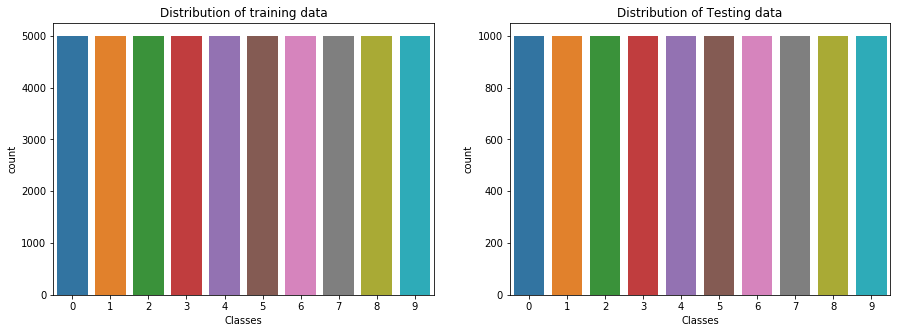

In [4]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [5]:
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
import torch.nn as nn

class ConvNet(nn.Module):
   def __init__(self):
       super(ConvNet, self).__init__()
       self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
       self.relu1 = nn.ReLU(inplace=True)
       self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
       self.relu2 = nn.ReLU(inplace=True)
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.dropout1 = nn.Dropout(p=0.25)

       self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
       self.relu3 = nn.ReLU(inplace=True)
       self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
       self.relu4 = nn.ReLU(inplace=True)
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.dropout2 = nn.Dropout(p=0.25)

       self.fc1 = nn.Linear(64 * 7 * 7, 512)
       self.relu5 = nn.ReLU(inplace=True)
       self.dropout3 = nn.Dropout(p=0.5)
       self.fc2 = nn.Linear(512, num_classes)

   def forward(self, x):
       x = self.relu1(self.conv1(x))
       x = self.relu2(self.conv2(x))
       x = self.pool1(x)
       x = self.dropout1(x)

       x = self.relu3(self.conv3(x))
       x = self.relu4(self.conv4(x))
       x = self.pool2(x)
       x = self.dropout2(x)

       x = x.view(x.size(0), -1)
       x = self.relu5(self.fc1(x))
       x = self.dropout3(x)
       x = self.fc2(x)
       return x

model = ConvNet()
torchinfo.summary(model, (1, 3, 224, 224), row_settings=['var_names'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [7]:
# initiate RMSprop optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=1e-6)

# Let's train the model using RMSprop
criterion = nn.CrossEntropyLoss()

In [8]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")
        

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 12s 243us/step - loss: 1.8138 - accuracy: 0.3334 - val_loss: 1.5398 - val_accuracy: 0.4441
Epoch 2/100
50000/50000 [==============================] - 9s 182us/step - loss: 1.4848 - accuracy: 0.4628 - val_loss: 1.4551 - val_accuracy: 0.4772
Epoch 3/100
50000/50000 [==============================] - 9s 186us/step - loss: 1.3519 - accuracy: 0.5196 - val_loss: 1.3069 - val_accuracy: 0.5376
Epoch 4/100
50000/50000 [==============================] - 9s 182us/step - loss: 1.2555 - accuracy: 0.5550 - val_loss: 1.1877 - val_accuracy: 0.5779
Epoch 5/100
50000/50000 [==============================] - 9s 180us/step - loss: 1.1745 - accuracy: 0.5867 - val_loss: 1.0960 - val_accuracy: 0.6159
Epoch 6/100
50000/50000 [==============================] - 9s 179us/step - loss: 1.1158 - accuracy: 0.6087 - val_loss: 1.0378 - val_accuracy: 0.6402
Epoch 7/100
50000/50000 [=

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


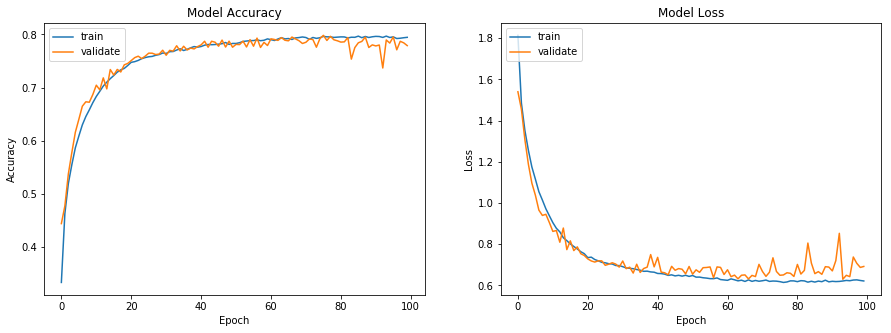

In [9]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)


In [10]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

10000/10000 [==============================] - 1s 85us/step
Test loss: 0.6918935515880584
Test accuracy: 0.7789000272750854


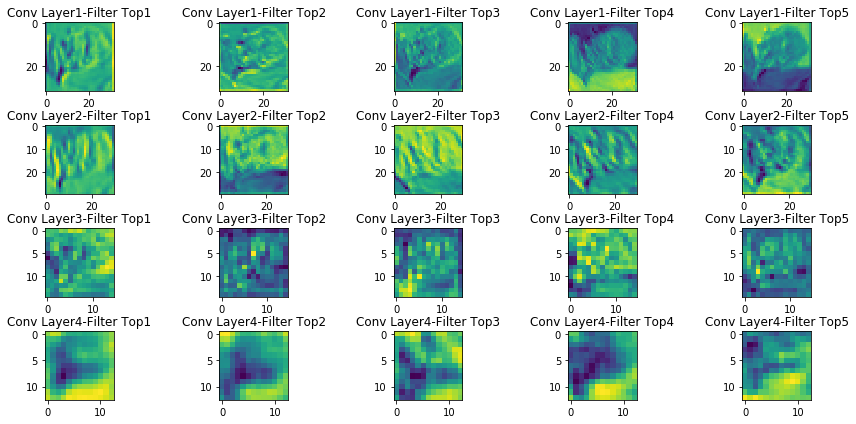

In [11]:
import matplotlib.pyplot as plt

# layers = ["activation_6", "activation_7", "activation_8", "activation_9"]
layers = [0, 2, 6, 8]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 6))

for j in range(4):
   layer_ind = layers[j]
   dense1_layer_model = models.Model(inputs=model.input, outputs=model.layers[layer_ind].output)
   dense1_output = dense1_layer_model.predict(x=x_test)
   dense1_output = torch.transpose(dense1_output, [0, 3, 1, 2])

   sum_per_image = np.sum(dense1_output[0], axis=(1, 2))
   sorted_indices = np.argsort(sum_per_image)
   top_five_indices = sorted_indices[:5]
   top_five_images = np.array(dense1_output[0])[top_five_indices]
   
   for i in range(5):
       axes[j, i].imshow(top_five_images[i])
       axes[j, i].set_title(f'Conv Layer{j+1}-Filter Top{i+1}')

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [12]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

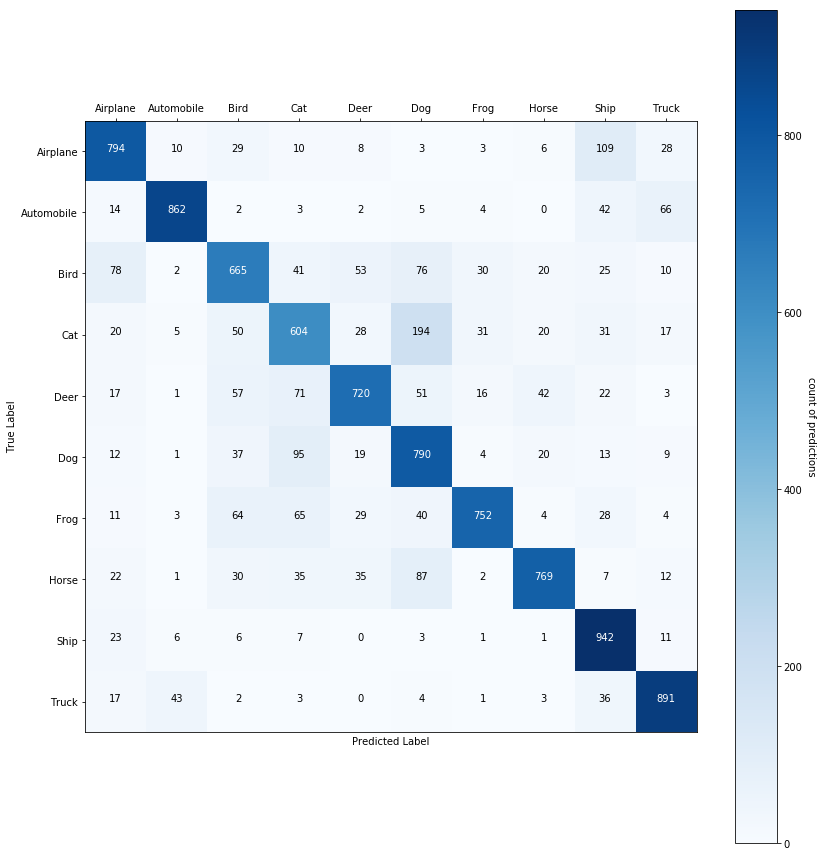

In [13]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [14]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1000
           1       0.92      0.86      0.89      1000
           2       0.71      0.67      0.68      1000
           3       0.65      0.60      0.62      1000
           4       0.81      0.72      0.76      1000
           5       0.63      0.79      0.70      1000
           6       0.89      0.75      0.82      1000
           7       0.87      0.77      0.82      1000
           8       0.75      0.94      0.84      1000
           9       0.85      0.89      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



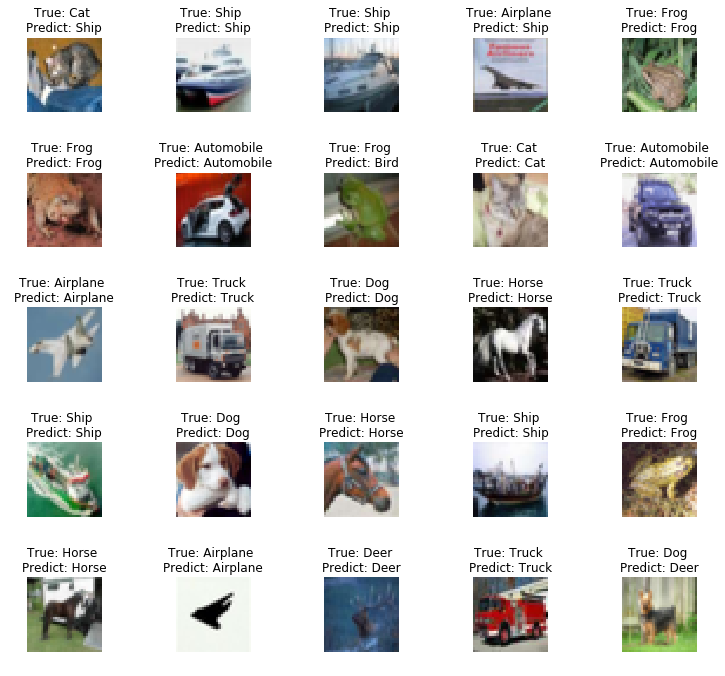

In [15]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


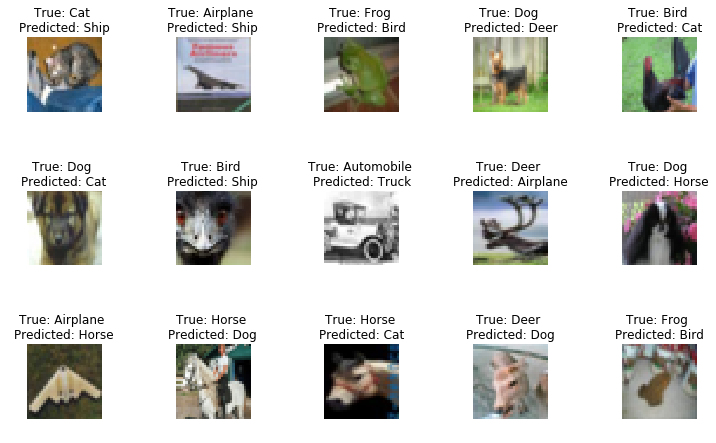

In [16]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


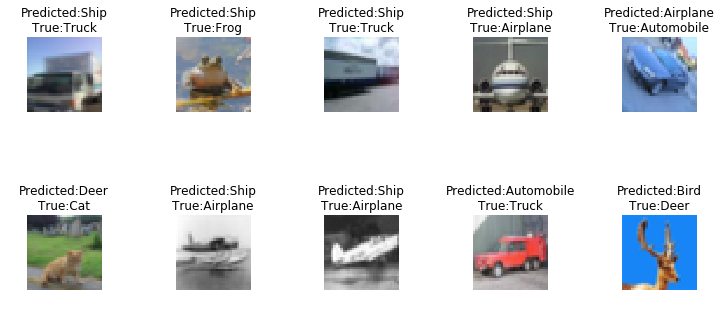

In [17]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(12,6))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted:{}\nTrue:{}".
                                  format(labels[pred_errors[error]],labels[obs_errors[error]]))
            n += 1
            ax[row,col].axis('off')
            plt.subplots_adjust(wspace=1)

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

In [18]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

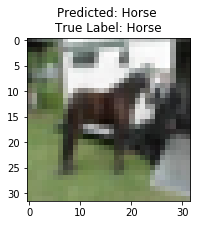

In [19]:
show_test(20)

In [20]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Saved trained model at /kaggle/working/saved_models/keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 1s 83us/step
Test loss: 0.6918935515880584
Test accuracy: 0.7789000272750854
